In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
# Oil company stock symbols
symbol_list = ['XOM', 'CVX', 'BP', 'SHEL', 'TTE']

In [3]:
# Download data
data = yf.download(
    symbol_list,
    start='2020-01-01',
    end='2024-09-12'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [5]:
# Find cointegrated pairs
scores, pvalues, pairs = find_cointegrated_pairs(data)

In [6]:
# Print cointegrated pairs
print("Cointegrated pairs:")
for pair in pairs:
    print(f"{pair[0]} - {pair[1]}")

Cointegrated pairs:
BP - XOM
SHEL - TTE


In [7]:
bp = data['BP']
xom = data['XOM']

In [8]:
# Calculate hedge ratio using linear regression
X = xom.values.reshape(-1, 1)
y = bp.values
model = LinearRegression().fit(X, y)
hedge_ratio = model.coef_[0]

In [9]:
# Compute the spread
spread = bp - hedge_ratio * xom

In [10]:
# Normalise the spread (calculate z-score)
z_score = (spread - spread.mean()) / spread.std()

In [11]:
# Set entry and exit thresholds
entry_threshold = 2
exit_threshold = 0

In [12]:
# Initialise position and portfolio
position = 0
portfolio = pd.Series(index=data.index, dtype=float)
portfolio.iloc[0] = 1  # Start with $1

In [13]:
# Implement trading logic
for i in range(1, len(data)):
    if position == 0:
        if z_score.iloc[i] > entry_threshold:
            position = -1  # Short BP, Long XOM
        elif z_score.iloc[i] < -entry_threshold:
            position = 1   # Long BP, Short XOM
    elif position == 1 and z_score.iloc[i] >= -exit_threshold:
        position = 0
    elif position == -1 and z_score.iloc[i] <= exit_threshold:
        position = 0
# Calculate returns
    bp_return = bp.iloc[i] / bp.iloc[i-1] - 1
    xom_return = xom.iloc[i] / xom.iloc[i-1] - 1
    strategy_return = position * (bp_return - hedge_ratio * xom_return)
    
    # Update portfolio value
    portfolio.iloc[i] = portfolio.iloc[i-1] * (1 + strategy_return)

In [14]:
# Calculate performance metrics
total_return = portfolio.iloc[-1] - 1
annual_return = (portfolio.iloc[-1] ** (252 / len(portfolio))) - 1
sharpe_ratio = np.sqrt(252) * portfolio.pct_change().mean() / portfolio.pct_change().std()
max_drawdown = (portfolio / portfolio.cummax() - 1).min()

print(f"Hedge Ratio: {hedge_ratio:.4f}")
print(f"Total Return: {total_return:.4f}")
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")

Hedge Ratio: 0.2200
Total Return: 1.2026
Annual Return: 0.1835
Sharpe Ratio: 1.1108
Max Drawdown: -0.1338


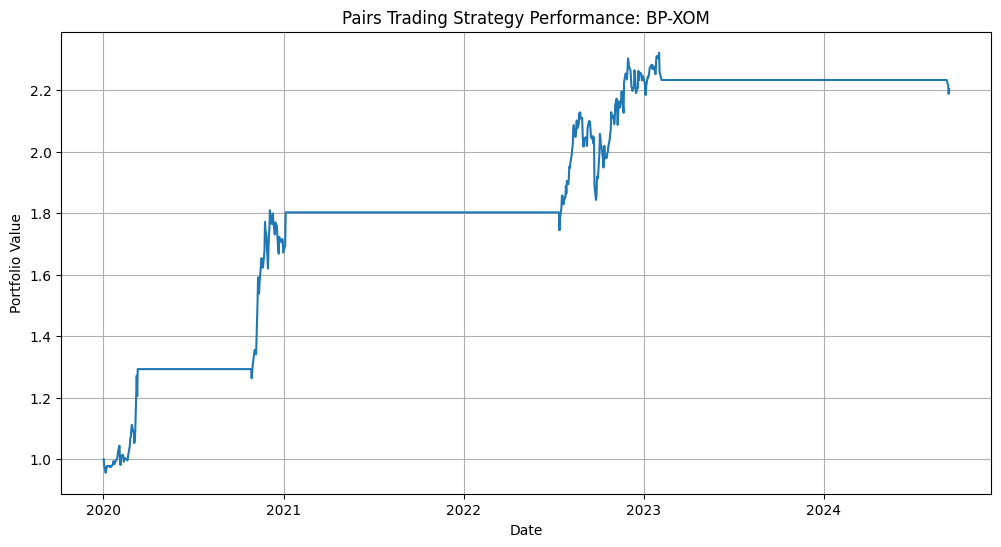

In [15]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(portfolio)
plt.title('Pairs Trading Strategy Performance: BP-XOM')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

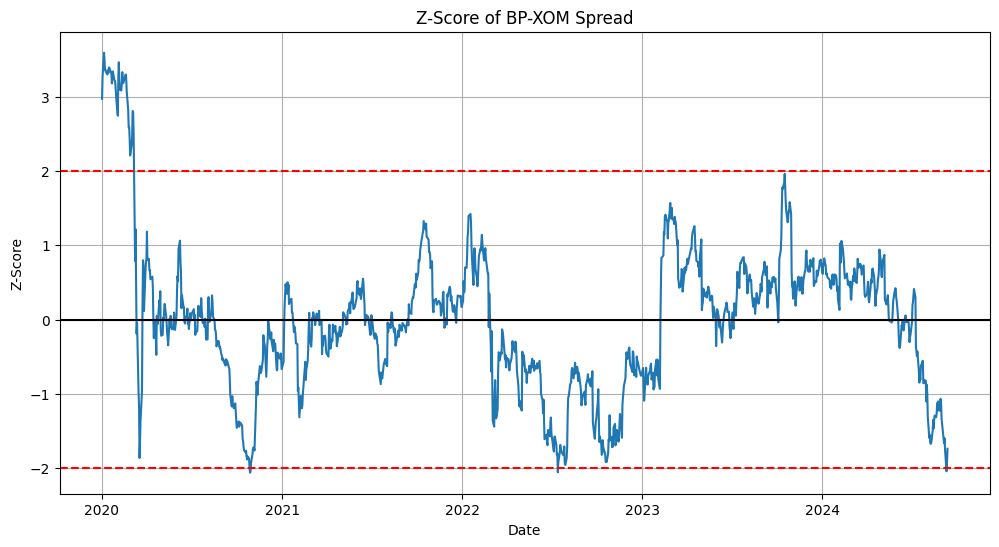

In [16]:
# Plot the spread and trading signals
plt.figure(figsize=(12, 6))
plt.plot(z_score)
plt.axhline(y=entry_threshold, color='r', linestyle='--')
plt.axhline(y=-entry_threshold, color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Z-Score of BP-XOM Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.grid(True)
plt.show()